In these exercises we will assume a modern camera with completely square pixels. What are the
skew parameters then?



The skew parameters typically include:

Horizontal Skew (α): This parameter represents the angle of rotation around the horizontal axis, causing horizontal lines in the scene to appear slanted in the captured image.

Vertical Skew (β): This parameter represents the angle of rotation around the vertical axis, causing vertical lines in the scene to appear slanted in the captured image.

Exercise 2.1
Reuse the box3d function from last week. Assume that f = 600, α = 1, β = 0, and δx = δy = 400.
Given a traditional camera, what is the resolution in pixels?
Also assume R = I, and t = [0, .2, 1.5]T. Use projectpoints from last week, to project the
points.
Are all the points are captured by the image sensor?
Where does the corner P1 = [−0.5,−0.5,−0.5] project to?


In [1]:
import cv2 
import matplotlib.pyplot as plt
import numpy as np
import itertools as it
import utilis

[[100.]
 [220.]]
[[600.    0.  400.  600. ]
 [  0.  600.  400.  720. ]
 [  0.    0.    1.    1.5]]


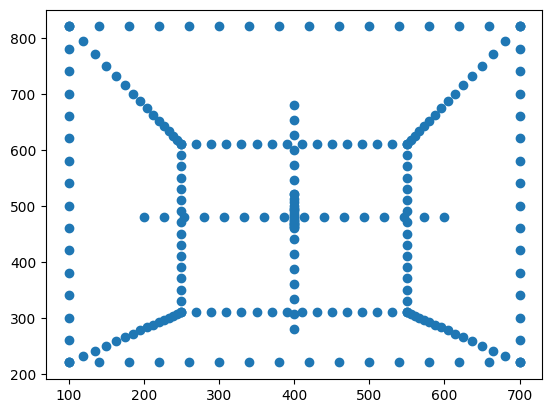

In [15]:
t=np.array([[0],[.2], [1.5]])
K = np.array([[600, 0, 400], [0, 600, 400], [0, 0, 1]])
R = np.eye(3)
Q= np.array([[-0.5,-0.5,-0.5]]).T
print(utilis.projectpoints(K, R, t, Q))


P = utilis.getProjection_Matrix(K, R, t)
print(P)

Q = utilis.box3d(16)
q = utilis.projectpoints(K, R, t, Q)
plt.scatter(p[0,:], p[1,:])
plt.show()

Create a new or change your function projectpoints to a version that also takes distCoeffs as
an input. The list distCoeffs should contain the distortion coefficients [k3, k5, k7, . . . ]. Make the
function work for at least 3 coefficients.
Test your function with the same setup as in Exercise 2.1 and but assume that the distortion is
Δr(r) = −0.2r2 .

In [16]:
def projectpoints(K, R, t, Q, distCoeffs=[]):
    transformation_matrix = np.concatenate((R, t), axis=1)
    projection_matrix = transformation_matrix@utilis.PiInv(Q)
    distortion = utilis.distort(projection_matrix, distCoeffs)
    projection_points = K@distortion
    return utilis.Pi(projection_points)


In [17]:
def projectpoints(K:np.ndarray, R: np.ndarray, t: np.ndarray, Q: np.ndarray, distCoeffs=[], dist = False):
    """
        Parameters:
    - K: Camera matrix (3x3)
    - R: Rotation matrix (3x3)
    - t: Translation vector (3x1)
    - Q: 3xN matrix representing N 3D points in columns
    - distCoeffs: List of distortion coefficients ([])
    - dist: boolean to decide if the distortion is applied

    Returns:
    - 2xN matrix representing the projected 2D points in columns.
    """
    transformation_matrix = np.concatenate((R, t), axis=1)
    projection_matrix = transformation_matrix@utilis.PiInv(Q)
    if dist == True:
        distortion = utilis.distort(projection_matrix, distCoeffs)
        projection_points = K@distortion
        print(distortion.shape)
    else:
        projection_points = K@projection_matrix
    return utilis.Pi(projection_points)

(3, 240)
Projected points with distortion correction: (2, 240)


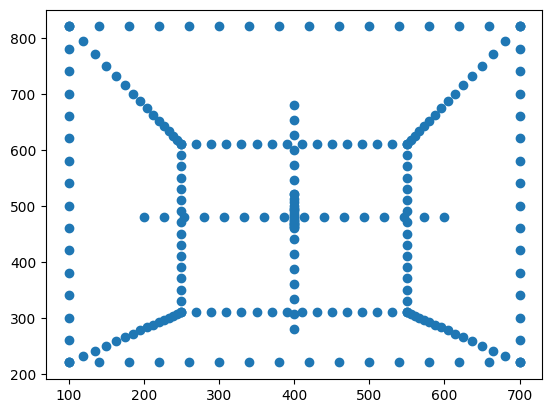

In [18]:
# Define distortion coefficients for ∆r(r) = -0.2r2
distCoeffs = [-0.2]

# Use the updated function with your existing setup
projected_points = projectpoints(K, R, t, Q, distCoeffs, True)

print("Projected points with distortion correction:", projected_points.shape)

Q = utilis.box3d(16)
q = projectpoints(K, R, t, Q, distCoeffs)
plt.scatter(q[0,:], q[1,:])
plt.show()


Are all the points captured by the image sensor?

Plot the results and try changing the distortion coefficients. Do they behave as they should?

Exercise 2.3
Download the following image:
https://people.compute.dtu.dk/mohan/02504/gopro_robot.jpg
The image has been captured using a GoPro. Assume that the focal length is 0.455732 times the
image width, and a reasonable guess of principal point, α, and β. The distortion coefficients are
k3 = −0.245031, k5 = 0.071524, k7 = −0.00994978
What is K?

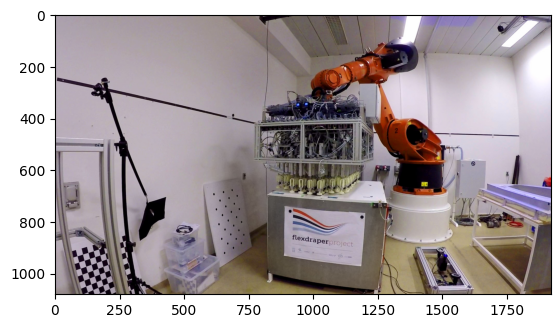

In [19]:
image = cv2.imread("images/gopro_robot.jpg")
image = image[:,:,::-1]
plt.imshow(image)

In [20]:
# Get the width and height of the image
width = image.shape[1]
height = image.shape[0]

# Principal points are half of the height and width of the image
ppy= height /2
ppx = width /2

#get the focal length
f_length= int( width * 0.455732) 


K = np.array([[f_length, 0, ppx], [0, f_length, ppy], [0,0,1]])

print(K)

[[875.   0. 960.]
 [  0. 875. 540.]
 [  0.   0.   1.]]


The distortion coefficient do not affect the camera matrix, but they are multiplied with the projection matrix

Exercise 2.4
Implement a function undistortImage that takes an image, a camera matrix, and distortion
coefficients and returns an undistorted version of the same image. Use the following as an outline
of your function


    Undistorts an image given camera matrix and distortion coefficients.

    Args:
        im: Input image (as a NumPy array).
        K: Camera intrinsic matrix (3x3).
        distCoeffs: Distortion coefficients (1xn).

    Returns:
        Undistorted image.



In [21]:
def undistortImage(im, K, distCoeffs):
   
    # Create a grid of normalized pixel coordinates
    x, y = np.meshgrid(np.arange(im.shape[1]), np.arange(im.shape[0]))
    p = np.stack((x, y, np.ones(x.shape))).reshape(3, -1)  # Homogeneous coordinates

    # Apply camera matrix to transform points to normalized image coordinates
    q = np.linalg.inv(K) @ p

    # Apply inverse distortion model
    q_d = utilis.distort(q, distCoeffs)
    p_d = K @ q_d

    # Reshape and convert to float32 for remapping
    x_d = p_d[0].reshape(x.shape).astype(np.float32)
    y_d = p_d[1].reshape(y.shape).astype(np.float32)

    # Sanity check (ensure homogeneous coordinates are valid)
    assert (p_d[2] == 1).all(), 'You did a mistake somewhere'

    # Apply remapping to get the undistorted image
    im_undistorted = cv2.remap(im, x_d, y_d, cv2.INTER_LINEAR)

    return im_undistorted

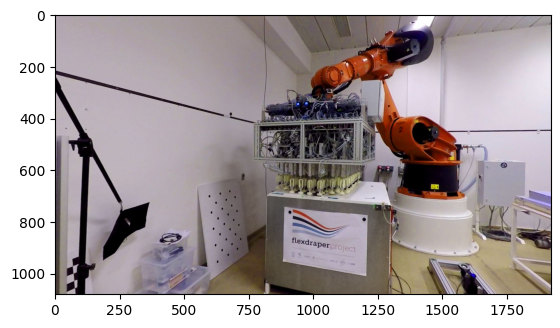

In [22]:
#Test undistorted image
distCoeffs= [-0.245031, 0.071524, -0.00994978]
im_ud = undistortImage(image, K, distCoeffs)
plt.imshow(im_ud)

### 2.5 Homography
Given four points on a plane, use a given homography matrix to map the points to an image plane.

(The advantage of knowing the plane coordinates for the points is that we can use the 3x3 H matrix, instead of the 3x4 projection matrix.)

In [ ]:
# Define all points and H matrix.
p1 = np.array([[1, 1]]).T
p2 = np.array([[0, 3]]).T
p3 = np.array([[2, 3]]).T
p4 = np.array([[2, 4]]).T
points = np.array([p1, p2, p3, p4])
print(points)
H = np.array([[-2, 0, 1], [1, -2, 0], [0, 0, 3]])

[[[1]
  [1]]

 [[0]
  [3]]

 [[2]
  [3]]

 [[2]
  [4]]]


In [ ]:
def homography_mapping(q, H):
    ''' Calculats mapping to image plane, given H matrix.
    Nb! Assumes q is homogenous coordinate!'''
    return utilis.Pi(H@q)

q2 = np.array([[1, 0, 2, 2], [1, 3, 3, 4]])
q2 = utilis.PiInv(q2)
print(q2.shape)
q1= homography_mapping(q2,H)
print(q1)

(3, 4)
[[-0.33333333  0.33333333 -1.         -1.        ]
 [-0.33333333 -2.         -1.33333333 -2.        ]]


Homographies: Exercise 2.6
Create a function hest that takes two sets of points in 2D, q1 and q2, and returns the estimated
homography matrix using the linear algorithm.
Test your function by using the points from the exercise above. Do you get the exact same numbers
in your homography, or are they scaled? Explain why this is fine. You should obtain the same homography, but multiplied with a scalar such that ∥H∥F =1

### 2.6 Estimate H - matrix
H matrix is a 3x3 matrix, but as it is scale invariant it has 8 degrees of freedom. Using 4 pais of (x,y) plane-points, we can therefor estimate H (as each pair implies 2 restrictions).
1. Calculate the B matrix = [B1, B2, B3, ...].T - one for each pair of point, by using kronecker and crossup operations.
2. Use SVD to solve the B flatten(H).T = 0 system (Ax = 0), by imposing that ||x|| = 1, to avoid the trivial solution.

In [ ]:
def format_H_to_solution(H):
    ''' Helper function to scale H to appropriate value'''
    return H*(-2/H[0][0])

def normalize2d(q):
    """
    Normalize 2D points.

    q : 2 x n, 2D points
    qn : 2 x n, normalized 2D points
    """
    if q.shape[0] != 2:
        raise ValueError("q must have 2 rows")
    if q.shape[1] < 2:
        raise ValueError("At least 2 points are required to normalize")

    mu = np.mean(q, axis=1).reshape(-1, 1)
    mu_x = mu[0].item()
    mu_y = mu[1].item()
    std = np.std(q, axis=1).reshape(-1, 1)
    std_x = std[0].item()
    std_y = std[1].item()
    Tinv = np.array([[std_x, 0, mu_x], [0, std_y, mu_y], [0, 0, 1]])
    T = np.linalg.inv(Tinv)
    qn = T @ utilis.PiInv(q)
    qn = utilis.Pi(qn)
    return qn, T

def hest(q1, q2, normalize=False):
    """
    Calculate the homography matrix from n sets of 2D points
    q1 : 2 x n, 2D points in the first image
    q2 : 2 x n, 2D points in the second image
    H : 3 x 3, homography matrix
    """
    if q1.shape[1] != q2.shape[1]:
        raise ValueError("Number of points in q1 and q2 must be equal")
    if q1.shape[1] < 4:
        raise ValueError(
            "At least 4 points are required to estimate a homography"
        )
    if q1.shape[0] != 2 or q2.shape[0] != 2:
        raise ValueError("q1 and q2 must have 2 rows")

    if normalize:
        q1, T1 = normalize2d(q1)
        q2, T2 = normalize2d(q2)

    n = q1.shape[1]
    B = []
    for i in range(n):
        x1, y1 = q1[:, i]
        x2, y2 = q2[:, i]
        Bi = np.array(
            [
                [0, -x2, x2 * y1, 0, -y2, y2 * y1, 0, -1, y1],
                [x2, 0, -x2 * x1, y2, 0, -y2 * x1, 1, 0, -x1],
                [-x2 * y1, x2 * x1, 0, -y2 * y1, y2 * x1, 0, -y1, x1, 0],
            ]
        )
        B.append(Bi)
    # with np.printoptions(precision=3, suppress=True):
    #     print("B:", B)
    B = np.array(B).reshape(-1, 9)
    U, S, Vt = np.linalg.svd(B)
    H = Vt[-1].reshape(3, 3)
    H = H.T
    if normalize:
        H = np.linalg.inv(T1) @ H @ T2
    return H

q2 = np.array([[1, 0, 2, 2], [1, 3, 3, 4]])
q1 = np.array([[-0.33333333, 0.33333333, -1, -1], [-0.33333333, -2, -1.33333333, -2]])
H_est = hest(q1, q2, True) 

print("Q1")
print(q1)
print("Q2")
print(q2)
print("Given H")
print(H)
print("H estimated")
print(H_est)

print('error with norm: ', np.linalg.norm(H_est))



Q1
[[-0.33333333  0.33333333 -1.         -1.        ]
 [-0.33333333 -2.         -1.33333333 -2.        ]]
Q2
[[1 0 2 2]
 [1 3 3 4]]
Given H
[[-2  0  1]
 [ 1 -2  0]
 [ 0  0  3]]
H estimated
[[ 3.67070940e-01  6.19432278e-10 -1.83535472e-01]
 [-1.83535476e-01  3.67070943e-01  2.34007624e-09]
 [ 2.89068365e-09 -6.19432428e-10 -5.50606413e-01]]
error with norm:  0.8000125712810278


Improve your hest function by adding an option (normalize=true/false) to normalize the points
with normalize2d before estimating the homography. Apply the T matrices to the estimated H
so the estimated homography still operates on non-normalized points.

Generate 100 random 2D points, and a random homography. Map the points using the homography, and use hest to estimate the homography from the points. You can use the following code
as a starting point:

In [ ]:
q2 = np.random.randn(2, 100)
q2h = np.vstack((q2, np.ones((1, 100))))
H_true = np.random.randn(3, 3)
q1h = H_true @ q2h
q1 = utilis.Pi(q1h)

H_est = hest(q1, q2, True)
print("True Homography: \n", H_true / np.linalg.norm(H_true, "fro"))
print("Estimated Homography: \n", H_est)
print('error without norm: ', np.linalg.norm(H_true - H_est))

True Homography: 
 [[ 0.3371449  -0.5797231   0.45076041]
 [-0.45322623  0.06152902 -0.08294625]
 [ 0.0441333   0.34504075  0.09994349]]
Estimated Homography: 
 [[ 0.89074505 -1.5316426   1.19092003]
 [-1.19743478  0.16256118 -0.21914602]
 [ 0.11660125  0.9116061   0.26405314]]
error without norm:  1.2917983659661856


Take a piece of paper and draw at least four ×-marks on it in random locations. Make sure to
number them.
Put a small object on top of the paper, and use your phone to take pictures of your paper from
two different viewpoints (A and B) Get the x, y coordinates of your ×-marks in image coordinates.
You can get the coordinates of clicked points with plt.ginput

In [ ]:
%matplotlib qt

In [ ]:
def load_and_annotate(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    plt.imshow(image)
    plt.axis('on')
    points = plt.ginput(4)  # Assuming you want to select 4 points
    plt.close()
    return points
# Load and annotate Image A
points_A = load_and_annotate('images/paper_1.jpg')

# Load and annotate Image B
points_B = load_and_annotate('images/paper_2.jpg')
# Print the coordinates
for i, (x, y) in enumerate(points_A):
    print(f"Point {i+1}: ({x}, {y})")
for i, (x, y) in enumerate(points_B):
    print(f"Point {i+1}: ({x}, {y})")

points_A

Point 1: (760.322510822511, 499.5)
Point 2: (1117.4653679653684, 824.1753246753246)
Point 3: (684.5649350649351, 1094.7380952380952)
Point 4: (608.8073593073593, 1516.8160173160172)
Point 1: (397.7683982683984, 504.9112554112553)
Point 2: (949.7164502164503, 699.7164502164501)
Point 3: (749.5000000000002, 1224.608225108225)
Point 4: (949.7164502164503, 1695.387445887446)


[(760.322510822511, 499.5),
 (1117.4653679653684, 824.1753246753246),
 (684.5649350649351, 1094.7380952380952),
 (608.8073593073593, 1516.8160173160172)]

In [ ]:
points_A = np.array([[760.322510822511, 1112.0541125541126, 695.3874458874459, 625.0411255411257 ], 
                     [515.7337662337661, 813.3528138528138, 1100.1493506493507, 1489.7597402597403], ])

print(points_A.shape)
points_B = np.array([[397.7683982683984, 949.7164502164503,738.6774891774894, 949.7164502164503 ], 
                     [499.5, 699.7164502164501, 1246.2532467532467, 1700.7987012987014], ])

print(normalize2d(points_A))

(2, 4)
(array([[-0.20211471,  1.67466471, -0.54859706, -0.92395294],
       [-1.28992041, -0.46256621,  0.33470238,  1.41778424]]), array([[ 5.33582823e-03,  0.00000000e+00, -4.25906503e+00],
       [ 0.00000000e+00,  2.77991011e-03, -2.72361392e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]]))


In [ ]:
#Hestimated Homography
H_est = hest(points_A, points_B) 
print(H_est)


[[-4.12939711e-03  1.87458694e-03  8.41778004e-01]
 [-3.07202798e-03  1.54981929e-03  5.39793204e-01]
 [-3.84299836e-06  1.76150849e-06  8.27082702e-04]]


Re-create image A, using only pixel intensities from image B. Generate an overlay of the two
images. Does the object on top align?
To accomplish this, use the following function:
def warpImage(im, H):
imWarp = cv2.warpPerspective(im, H, (im.shape[1], im.shape[0]))
return imWarp
It takes an image and a homography and returns the image warped with the homography.

In [ ]:
def warpImage(im, H):
    imWarp = cv2.warpPerspective(im, H, (im.shape[1], im.shape[0]))
    return imWarp

# Load Image B
image_B = cv2.imread('images/paper_2.jpg')

# Assuming H is the homography matrix you estimated earlier
image_B_warped = warpImage(image_B, H_est)

plt.imshow(image_B_warped)

# Load Image A
image_A = cv2.imread('images/paper_1.jpg')

# Convert images to float for blending
image_A_float = image_A.astype(float)
image_B_warped_float = image_B_warped.astype(float)

# Normalize the images to [0, 1]
image_A_normalized = image_A_float / 255.0
image_B_warped_normalized = image_B_warped_float / 255.0

# Create an overlay by averaging
overlay = 0.5 * image_A_normalized + 0.5 * image_B_warped_normalized

# Display the overlay
plt.imshow(cv2.cvtColor(overlay.astype('float32'), cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


### DISTORTION WITH CV2

In [ ]:
def undistort_image(distorted_image, camera_matrix, dist_coeffs):
    """
    Undistort an entire image.

    Parameters:
    distorted_image (ndarray): Distorted input image.
    camera_matrix (ndarray): 3x3 camera matrix.
    dist_coeffs (ndarray): 1x5 distortion coefficients.

    Returns:
    undistorted_image (ndarray): Undistorted output image.
    """
    h, w = distorted_image.shape[:2]
    new_camera_matrix, roi = cv2.getOptimalNewCameraMatrix(camera_matrix, dist_coeffs, (w, h), 1, (w, h))
    undistorted_image = cv2.undistort(distorted_image, camera_matrix, dist_coeffs, None, new_camera_matrix)
    x, y, w, h = roi
    undistorted_image = undistorted_image[y:y+h, x:x+w]
    return undistorted_image

# Example usage
distorted_image = cv2.imread('distorted_image.jpg')
camera_matrix = np.array([[fx, 0, cx], [0, fy, cy], [0, 0, 1]], dtype='float32')
dist_coeffs = np.array([k1, k2, p1, p2, k3, k4, k5, k6, k7], dtype='float32')

undistorted_image = undistort_image(distorted_image, camera_matrix, dist_coeffs)
cv2.imshow('Undistorted Image', undistorted_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
def undistort_points(distorted_points, camera_matrix, dist_coeffs):
    """
    Undistort points from a distorted image.

    Parameters:
    distorted_points (ndarray): Nx2 array of distorted points.
    camera_matrix (ndarray): 3x3 camera matrix.
    dist_coeffs (ndarray): 1x5 distortion coefficients.

    Returns:
    undistorted_points (ndarray): Nx2 array of undistorted points.
    """
    distorted_points = np.array(distorted_points, dtype='float32').reshape(-1, 1, 2)
    undistorted_points = cv2.undistortPoints(distorted_points, camera_matrix, dist_coeffs, P=camera_matrix)
    undistorted_points = undistorted_points.reshape(-1, 2)
    return undistorted_points

# Example usage
camera_matrix = np.array([[fx, 0, cx], [0, fy, cy], [0, 0, 1]], dtype='float32')
dist_coeffs = np.array([k1, k2, p1, p2, k3, k4, k5, k6, k7], dtype='float32')
distorted_points = np.array([[150, 150], [300, 300]], dtype='float32')

undistorted_points = undistort_points(distorted_points, camera_matrix, dist_coeffs)
print("Undistorted points:\n", undistorted_points)